In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
pip install scikit-surprise;

### Importing Libraries and Datasets

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
import altair as alt
from google.colab import auth
import gspread
from oauth2client.client import GoogleCredentials
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)
from surprise import SVD
import numpy as np
import surprise
from scipy.sparse import csr_matrix
from scipy.sparse import find
import datetime
from surprise import Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
%matplotlib inline
plt.close('all')

In [ ]:
df_links = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/links.csv")
df_movies = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/movies.csv")
df_ratings = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/ratings.csv")
df_tags = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/tags.csv")

## Exploratory Data Analysis

In [ ]:
df_ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [ ]:
df_movies = df_movies[df_movies['movieId']!=171749]

Extracting Year from movie name

In [ ]:
df_movies['Year'] = df_movies['title'].str.extract('.*\((.*)\).*',expand = False)

In [ ]:
movie_count = df_movies.groupby('Year').title.count()
print('Max No.of Movies Relesed =', movie_count.max())
for i in movie_count.index:
    if movie_count[i] == movie_count.max():
        print('Year =',i)
movie_count.describe()

Max No.of Movies Relesed = 311
Year = 2002


count    106.000000
mean      91.783019
std      102.227757
min        1.000000
25%       16.000000
50%       39.500000
75%      151.500000
max      311.000000
Name: title, dtype: float64

Creating a DataFrame with year and movie count in that year

In [ ]:
movie_year = pd.DataFrame(df_movies['title'].groupby(df_movies['Year']).count())
movie_year.reset_index(inplace=True)
movie_year

,Year,title
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1916,4
...,...,...
101,2014,278
102,2015,274
103,2016,218
104,2017,147


In [ ]:
X=movie_year['Year']

Y=movie_year['title']

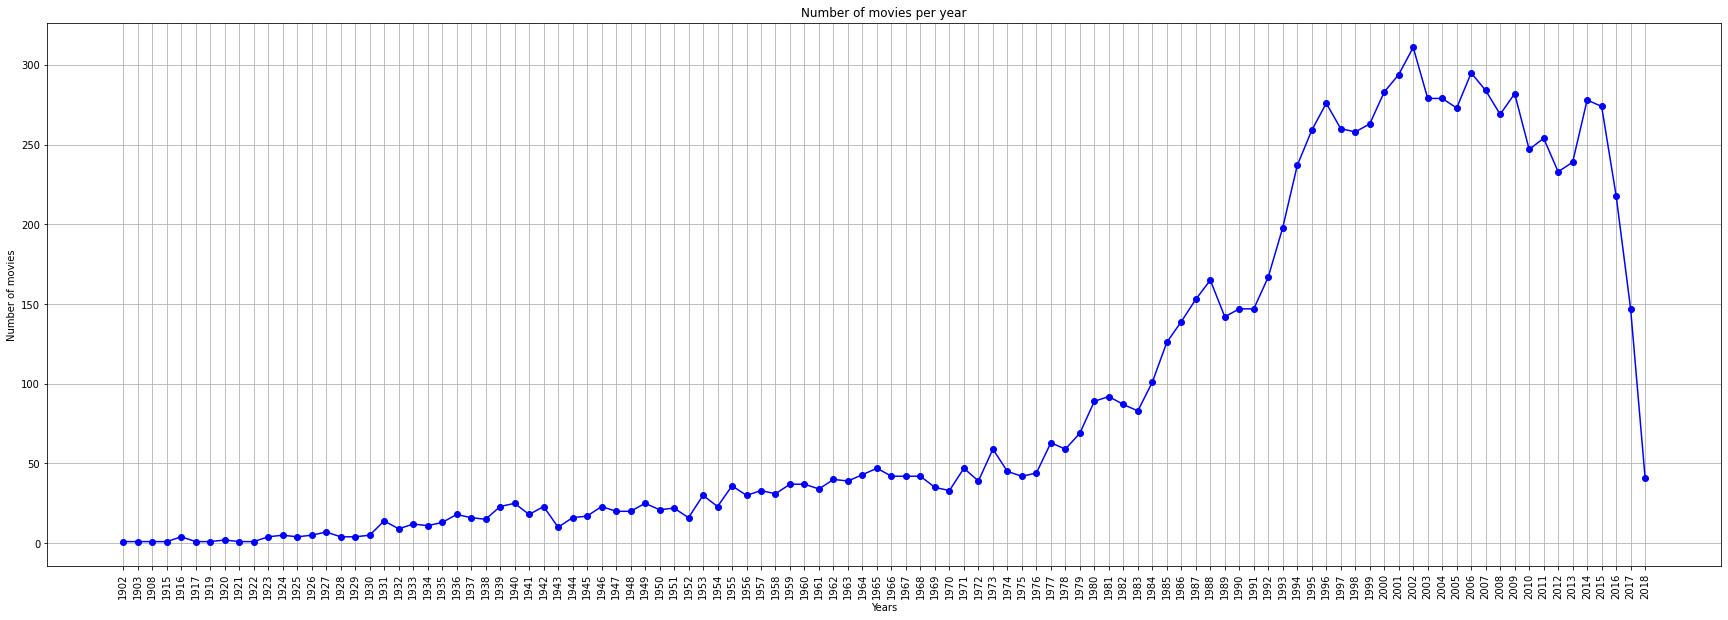

In [ ]:
plt.plot_date(X,Y,'bo-')
plt.grid(True)
plt.rcParams["figure.figsize"] = (35,10)
plt.title('Number of movies per year')
plt.xlabel('Years')
plt.ylabel('Number of movies')
plt.xticks(rotation='vertical')
plt.show()

Merging ratings and movies table

In [ ]:
df_movies = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/movies.csv")
df_movieUsers = df_ratings.merge(df_movies, on='movieId')
df_movieUsers.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
df_movieUsers=df_movieUsers.drop(['timestamp'], axis=1)

Creating column for each genre

In [ ]:
genres=[]
for i in range(len(df_movies.genres)):
    for x in df_movies.genres[i].split('|'):
        if x not in genres:
            genres.append(x)  
for i in genres:
    df_movies[i] = 0
for i in range(len(df_movies.genres)):
    for j in df_movies.genres[i].split('|'):
        df_movies[j][i]=1
df_movies.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


number of movies for each genre

In [ ]:
movie_count={}
for i in df_movies.columns[4:]:
    movie_count[i]=df_movies[i].value_counts()[1]
    print("{}    \t{}".format(i,movie_count[i]))

Animation    	611
Children    	664
Comedy    	3756
Fantasy    	779
Romance    	1596
Drama    	4361
Action    	1828
Crime    	1199
Thriller    	1894
Horror    	978
Mystery    	573
Sci-Fi    	980
War    	382
Musical    	334
Documentary    	440
IMAX    	158
Western    	167
Film-Noir    	87
(no genres listed)    	34


In [ ]:
df = pd.DataFrame(movie_count.items(), columns=['genres', 'Count'])
df.head(5)

,genres,Count
0,Animation,611
1,Children,664
2,Comedy,3756
3,Fantasy,779
4,Romance,1596


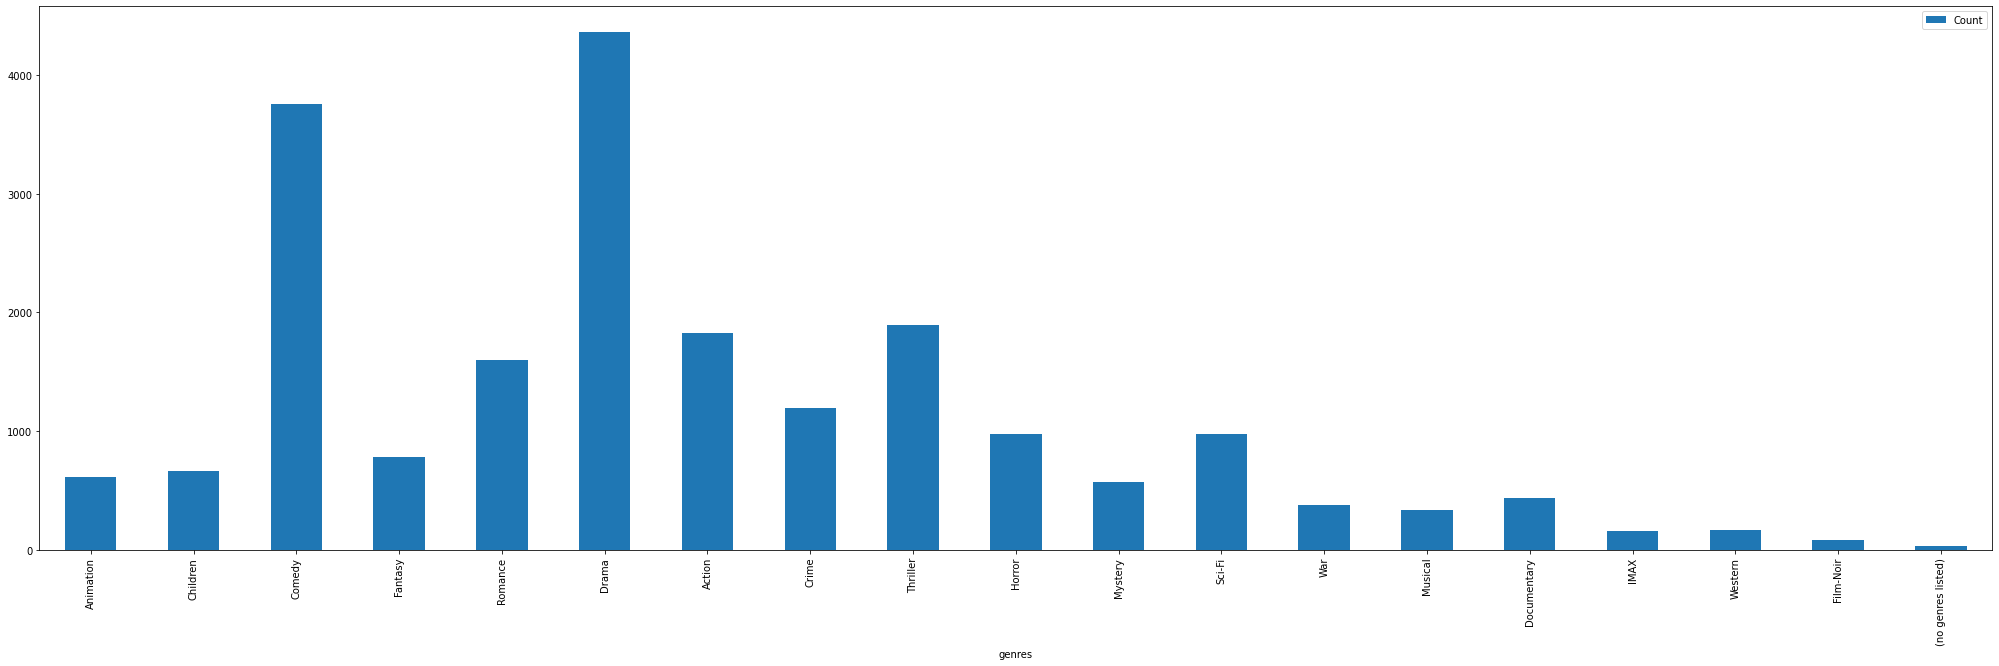

In [ ]:
df.plot(kind='bar',x='genres',y='Count')
plt.show()

Calculating mean rating for each genre

In [ ]:
genres = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
genres_rating = []
for i in range(len(genres)):
    movies = df_movies[df_movies['genres'].str.contains(genres[i])]
    ratings = movies.merge(df_ratings, on='movieId', how='inner')
    ratings_mean = round(ratings['rating'].mean(), 2)
    genres_rating.append(ratings_mean)

In [ ]:
avg_df = pd.DataFrame({'Genre':genres, 'Genres Mean Rating':genres_rating})
avg_df

,Genre,Genres Mean Rating
0,Action,3.45
1,Adventure,3.51
2,Animation,3.63
3,Children,3.41
4,Comedy,3.38
5,Crime,3.66
6,Documentary,3.80
7,Drama,3.66
8,Fantasy,3.49
9,Film-Noir,3.92


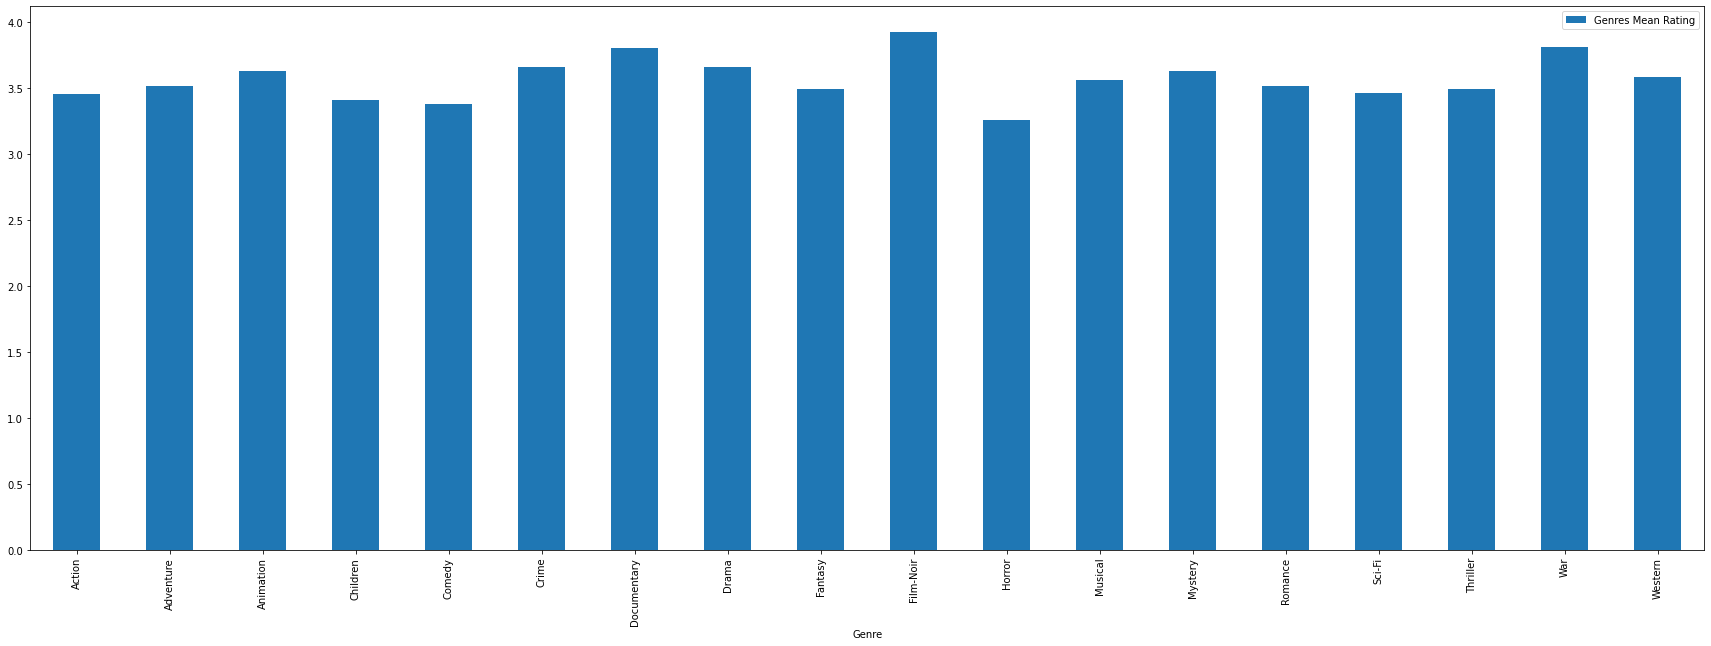

In [ ]:
avg_df.plot(kind='bar',x='Genre',y='Genres Mean Rating')
plt.show()

In [ ]:
avg_df.describe().T.style.format("{0:.2f}").bar(
    subset=['mean'], align='zero').background_gradient(
    subset=['std'], cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
Genres Mean Rating,18.00,3.57,0.16,3.26,3.47,3.54,3.65,3.92


Generating word cloud for Genre

In [ ]:
s = ''
for i in df_movies['genres']:
    s+=i
    s+=' '
print(s)
wc = ''
for i in s:
  if i == '|':
    wc+=' '
  else:
    wc += i

print(wc)

Adventure|Animation|Children|Comedy|Fantasy Adventure|Children|Fantasy Comedy|Romance Comedy|Drama|Romance Comedy Action|Crime|Thriller Comedy|Romance Adventure|Children Action Action|Adventure|Thriller Comedy|Drama|Romance Comedy|Horror Adventure|Animation|Children Drama Action|Adventure|Romance Crime|Drama Drama|Romance Comedy Comedy Action|Comedy|Crime|Drama|Thriller Comedy|Crime|Thriller Crime|Drama|Horror|Mystery|Thriller Action|Crime|Thriller Drama|Sci-Fi Drama|Romance Drama Children|Drama Drama|Romance Adventure|Drama|Fantasy|Mystery|Sci-Fi Crime|Drama Drama Mystery|Sci-Fi|Thriller Children|Drama Crime|Drama Children|Comedy Comedy|Romance Drama Drama|War Action|Crime|Drama Drama Action|Adventure|Fantasy Comedy|Drama|Thriller Drama|Romance Mystery|Thriller Animation|Children|Drama|Musical|Romance Drama|Romance Crime|Mystery|Thriller Comedy|Drama|Romance Adventure|Drama Children|Comedy Drama Drama Comedy|Drama|Romance Adventure|Children|Fantasy Drama|Thriller Drama Comedy|Crime Co

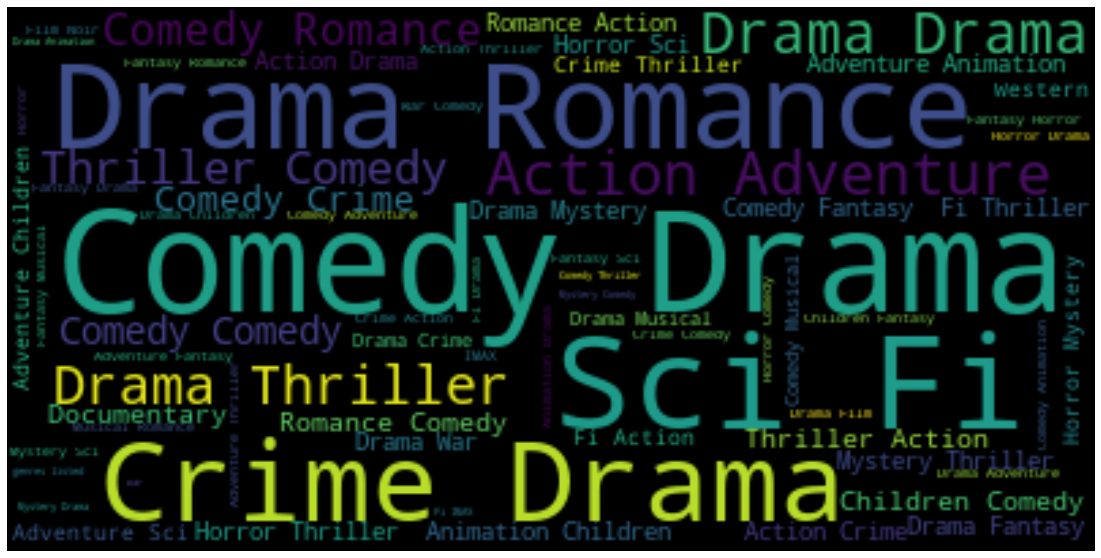

In [ ]:
wordcloud = WordCloud().generate(wc)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Creating word cloud for tags

['funny' 'Highly quotable' 'will ferrell' ... 'gun fu' 'heroic bloodshed'
 'Heroic Bloodshed']


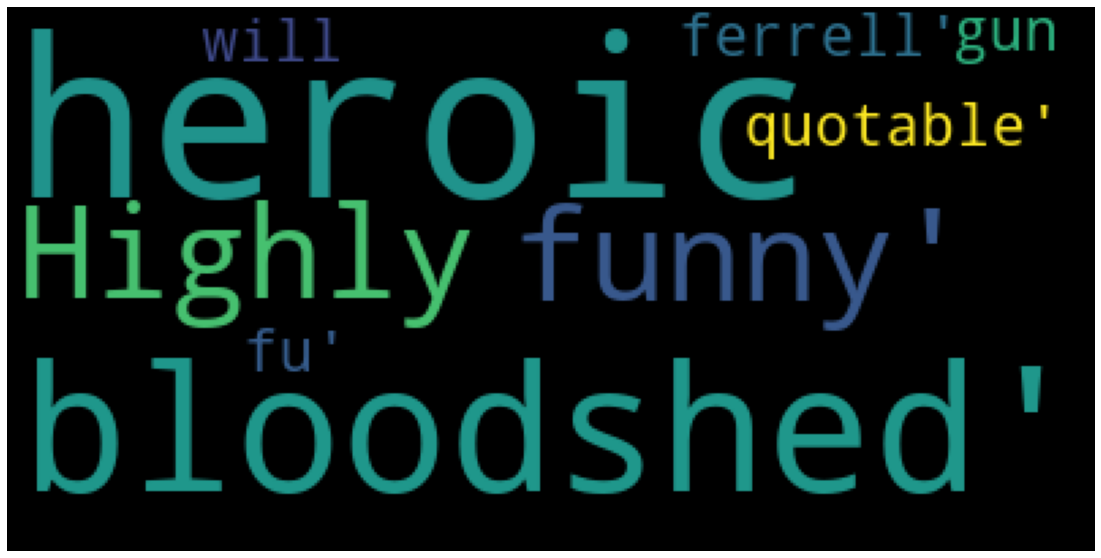

In [ ]:
text = df_tags['tag'].values 
print(text)
wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Collaborative Filtering -- Matrix Factorization method

In [ ]:
df_links = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/links.csv")
df_movies = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/movies.csv")
df_ratings = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/ratings.csv")
df_tags = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/tags.csv")

Filtering out Data from Ratings to Train the model

In [ ]:
reader = Reader(rating_scale=(1,5))
data = df_ratings.drop('timestamp',axis=1)
data

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [ ]:
test_data

,userId,movieId,rating
25800,177,116823,5.0
53776,354,8361,3.0
74285,474,4433,3.5
47972,310,4483,1.0
3126,20,4014,4.0
...,...,...,...
43023,288,7150,4.0
72859,469,3253,4.0
75975,477,58559,4.5
28704,199,1502,2.0


In [ ]:
data.shape

(100836, 3)

Building Training and testing Dataset for Matrix Factorization

In [ ]:
# create the traindata from the dataframe...
train_data_mf = Dataset.load_from_df(train_data[['userId', 'movieId', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
trainset = train_data_mf.build_full_trainset()

In [ ]:
# create the traindata from the dataframe...
test_data_mf = Dataset.load_from_df(test_data[['userId', 'movieId', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
testset = test_data_mf.build_full_trainset()

Applying Single-Value Decomposition on Training and Test sets

In [ ]:
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [ ]:
#getting predictions of trainset
train_preds = svd.test(trainset.build_testset())

train_pred_mf = np.array([pred.est for pred in train_preds])

In [ ]:
#getting predictions of trainset
test_preds = svd.test(testset.build_testset())

test_pred_mf = np.array([pred.est for pred in test_preds])

### XGBoost

In [ ]:
train_sparse_matrix = csr_matrix((train_data.rating.values, (train_data.userId.values,
                                               train_data.movieId.values)))

In [ ]:
train_sparse_matrix

<611x193610 sparse matrix of type '<class 'numpy.float64'>'
	with 80668 stored elements in Compressed Sparse Row format>

In [ ]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.501239648931423}

In [ ]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

Getting average ratings for User and Movies

In [ ]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.231132075471698


In [ ]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.25


In [ ]:
# get users, movies and ratings from our samples train sparse matrix
train_users, train_movies, train_ratings = find(train_sparse_matrix)

Building the final training dataset containing Top-5 similar user and movies for each combination of User and movies

In [ ]:
final_data = pd.DataFrame()
count = 0
start = datetime.datetime.now()
for (user, movie, rating)  in zip(train_users, train_movies, train_ratings):
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(train_sparse_matrix[user], train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(train_averages['user'][user])
            # Avg_movie rating
            row.append(train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            final_data = final_data.append([row])
            # print(count)
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.datetime.now() - start))
                start = datetime.datetime.now()

Done for 10000 rows----- 0:04:34.947038
Done for 20000 rows----- 0:04:38.207427
Done for 30000 rows----- 0:04:43.016684
Done for 40000 rows----- 0:04:44.691619
Done for 50000 rows----- 0:04:45.553822
Done for 60000 rows----- 0:04:48.644232
Done for 70000 rows----- 0:04:50.544000
Done for 80000 rows----- 0:04:51.651538


In [ ]:
final_data.columns=['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']

In [ ]:
final_data.shape

(80668, 16)

In [ ]:
final_data.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,1,1,3.502864,4.0,5.0,4.0,4.0,4.0,5.0,3.0,4.0,5.0,5.0,4.398936,3.968927,4.0
0,5,1,3.502864,5.0,4.0,5.0,4.0,4.0,4.0,3.0,5.0,3.0,4.0,3.812500,3.968927,4.0
0,7,1,3.502864,4.0,3.0,4.0,4.5,4.5,3.0,4.5,4.5,5.0,4.0,3.160000,3.968927,4.5
0,17,1,3.502864,4.0,5.0,4.0,5.0,0.5,4.0,3.5,4.5,4.0,4.5,4.201220,3.968927,4.5
0,18,1,3.502864,5.0,4.0,3.0,4.0,5.0,3.5,4.0,3.0,3.5,3.0,3.730140,3.968927,3.5


Adding the SVD trained reating to the training set

In [ ]:
final_data['mf_svd']=train_pred_mf
final_data.head(5)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,mf_svd
0,1,1,3.502864,4.0,5.0,4.0,4.0,4.0,5.0,3.0,4.0,5.0,5.0,4.398936,3.968927,4.0,3.117611
0,5,1,3.502864,5.0,4.0,5.0,4.0,4.0,4.0,3.0,5.0,3.0,4.0,3.812500,3.968927,4.0,3.479423
0,7,1,3.502864,4.0,3.0,4.0,4.5,4.5,3.0,4.5,4.5,5.0,4.0,3.160000,3.968927,4.5,3.975736
0,17,1,3.502864,4.0,5.0,4.0,5.0,0.5,4.0,3.5,4.5,4.0,4.5,4.201220,3.968927,4.5,3.794444
0,18,1,3.502864,5.0,4.0,3.0,4.0,5.0,3.5,4.0,3.0,3.5,3.0,3.730140,3.968927,3.5,3.284437


Preparing Test Data

In [ ]:
# Creating a sparse matrix
test_sparse_matrix = csr_matrix((test_data.rating.values, (test_data.userId.values,
                                               test_data.movieId.values)))

In [ ]:
# Global avg of all movies by all users

test_averages = dict()
# get the global average of ratings in our train set.
test_global_average = test_sparse_matrix.sum()/test_sparse_matrix.count_nonzero()
test_averages['global'] = test_global_average
test_averages

{'global': 3.5028262594208646}

In [ ]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [ ]:
# Average ratings given by a user

test_averages['user'] = get_average_ratings(test_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',test_averages['user'][10])

# Average ratings given for a movie

test_averages['movie'] =  get_average_ratings(test_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',test_averages['movie'][15])


Average rating of user 10 : 3.426470588235294

 AVerage rating of movie 15 : 2.1666666666666665


In [ ]:
# test_averages

In [ ]:
# get users, movies and ratings from our samples train sparse matrix
test_users, test_movies, test_ratings = find(test_sparse_matrix)

Building the final test dataset containing Top-5 similar user and movies for each combination of User and movies

In [ ]:
final_test_data = pd.DataFrame()
count = 0
start = datetime.datetime.now()
for (user, movie, rating)  in zip(test_users, test_movies, test_ratings):
            # st = datetime.datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(test_sparse_matrix[user], test_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = test_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([test_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(test_sparse_matrix[:,movie].T, test_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = test_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([test_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(test_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(test_averages['user'][user])
            # Avg_movie rating
            row.append(test_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1
            final_test_data = final_test_data.append([row])
            # print(count)
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.datetime.now() - start))
                start = datetime.datetime.now()


Done for 10000 rows----- 0:03:43.939205
Done for 20000 rows----- 0:03:45.570393


In [ ]:
final_test_data.columns=['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']

In [ ]:
final_test_data.shape

(20168, 16)

In [ ]:
test_pred_mf.shape

(20168,)

Adding the SVD trained reating to the test set

In [ ]:
final_test_data['mf_svd']=test_pred_mf
final_test_data.head(5)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,mf_svd
0,15,1,3.496331,4.0,3.0,4.5,5.0,4.0,5.0,3.0,5.0,4.0,3.0,3.583333,3.697368,2.5,3.055163
0,44,1,3.496331,5.0,5.0,3.0,4.0,4.0,3.0,3.0,5.0,3.0,4.0,3.500000,3.697368,3.0,3.198263
0,64,1,3.496331,5.0,3.0,4.0,5.0,3.0,4.0,4.5,3.5,3.5,1.5,3.696809,3.697368,4.0,2.822912
0,78,1,3.496331,4.0,4.0,4.0,5.0,4.5,3.0,5.0,3.5,2.5,4.5,3.300000,3.697368,4.0,2.712340
0,86,1,3.496331,4.0,4.0,3.0,5.0,4.5,3.5,4.5,3.5,4.0,3.5,3.600000,3.697368,4.0,2.880442


In [ ]:
final_test_data.to_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/outputs/final_test_data.csv")
final_data.to_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/outputs/final_data.csv")

In [ ]:
final_test_data = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/outputs/final_test_data.csv")
final_data = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/outputs/final_data.csv")

## creating XGBoost model

In [ ]:
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape

In [ ]:
# prepare train data
x_train = final_data.drop(['user', 'movie','rating'], axis=1)
y_train = final_data['rating']

In [ ]:
# Prepare Test data
x_test = final_test_data.drop(['user','movie','rating'], axis=1)
y_test = final_test_data['rating']

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
x_train_train, x_train_test, y_train_train, y_train_test = train_test_split(x_train, y_train)

In [ ]:
linreg = LinearRegression()

In [ ]:
linreg.fit(x_train_train, y_train_train)

LinearRegression()

In [ ]:
y_train_pred = linreg.predict(x_train_test)

In [ ]:
rmse_train, mape_train = get_error_metrics(y_train_test.values, y_train_pred)
print("RMSE on training data before XGBoost : {0}".format(rmse_train))
print("MAPE on training data before XGBoost : {0}".format(mape_train))

RMSE on training data before XGBoost : 0.7676190834898353
MAPE on training data before XGBoost : 25.14032557769898


In [ ]:
x_test_train, x_test_test, y_test_train, y_test_test = train_test_split(x_test, y_test)

In [ ]:
linreg.fit(x_test_train, y_test_train)

LinearRegression()

In [ ]:
y_test_pred = linreg.predict(x_test_test)

In [ ]:
rmse_test, mape_test = get_error_metrics(y_test_test.values, y_test_pred)
print("RMSE on testing data before XGBoost : {0}".format(rmse_test))
print("MAPE on testing data before XGBoost : {0}".format(mape_test))

RMSE on testing data before XGBoost : 0.7078724076114166
MAPE on testing data before XGBoost : 21.465663223822386


In [ ]:
## Applyting XGBoost

In [ ]:
import xgboost as xgb

In [ ]:
# initialize XGBoost model...
xgb_model = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
# dictionaries for storing train and test results
train_results = dict()
test_results = dict()    
# fit the model
print('Training the model..')
start = datetime.datetime.now()
xgb_model.fit(x_train, y_train, eval_metric = 'rmse')
print('Done. Time taken : {}\n'.format(datetime.datetime.now()-start))
print('Done \n')

Training the model..
[18:04:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Done. Time taken : 0:00:05.020298

Done 



In [ ]:
x_test.drop('rating_xgboost', axis=1, inplace=True)

In [ ]:
# from the trained model, get the predictions....
print('Evaluating the model with TRAIN data...')
start = datetime.datetime.now()
y_train_pred = xgb_model.predict(x_train)
# get the rmse and mape of train data...
rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
# store the results in train_results dictionary..
train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}

Evaluating the model with TRAIN data...


In [ ]:
train_results

{'mape': 24.50911485864543,
 'predictions': array([4.3732824, 4.0241585, 3.7492223, ..., 3.6739743, 3.6739743,
        4.233411 ], dtype=float32),
 'rmse': 0.7612402213604075}

In [ ]:
# get the test data predictions and compute rmse and mape
print('Evaluating Test data')
y_test_pred = xgb_model.predict(x_test) 
rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
# store them in our test results dictionary.
test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
test_results

Evaluating Test data


{'mape': 23.938527922400954,
 'predictions': array([3.8581526, 3.6216917, 3.7419538, ..., 2.9999313, 1.0367868,
        1.0367868], dtype=float32),
 'rmse': 0.7714926455791599}

Using XGBoost predictions on Test data to find the top 10 movies for each user

In [ ]:
final_test_data['rating_xgboost'] = test_results['predictions'].tolist()

In [ ]:
# final_test_data

In [ ]:
# R_df_final = final_test_data.pivot(index = 'user', columns ='movie', values = 'rating').fillna(0)
R_df_final = final_test_data.pivot(index = 'user', columns ='movie', values = 'rating_xgboost').fillna(0)
R_df_final.head()

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,41,42,44,45,...,177939,178129,178613,179133,179427,179511,179815,179819,179953,180031,180045,180095,180777,180985,181139,181719,182297,182639,182715,183199,183897,183911,184015,184053,184471,184791,184931,185029,185031,185135,187541,187593,187595,188675,188833,189381,190207,190209,190213,190221
user,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.195045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
R = R_df_final.values
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [ ]:
U, sigma, Vt = svds(R_demeaned, k = 50)

In [ ]:
sigma = np.diag(sigma)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df_final.columns)
preds_df

movie,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,41,42,44,45,...,177939,178129,178613,179133,179427,179511,179815,179819,179953,180031,180045,180095,180777,180985,181139,181719,182297,182639,182715,183199,183897,183911,184015,184053,184471,184791,184931,185029,185031,185135,187541,187593,187595,188675,188833,189381,190207,190209,190213,190221
0,1.200536,-0.128831,0.647072,0.182285,0.020364,0.273898,0.076097,0.053770,0.047964,0.091997,0.220162,0.065372,-0.125994,0.064027,-0.021405,0.274644,0.103405,0.148725,-0.436504,-0.055047,0.337808,0.082127,0.019109,-0.051587,0.050794,0.068747,0.040157,-0.008998,-0.171363,0.019192,0.283225,0.524633,-0.081580,0.118999,-0.006975,-0.065916,-0.287323,-0.008337,0.080718,0.052614,...,-0.005095,0.007154,0.005043,0.006885,0.127265,-0.011577,-0.012150,-0.184023,0.116146,-0.069022,-0.028250,-0.076850,-0.091892,-0.078390,0.061294,-0.068823,-0.037851,0.049234,0.012043,0.179383,0.009103,-0.008489,0.116146,-0.011274,0.062828,-0.023841,-0.020273,-0.020273,0.074871,0.080670,-0.029106,0.003884,-0.212607,0.012043,0.017316,0.007085,-0.005048,0.001570,-0.006447,-0.006447
1,0.060738,-0.029612,-0.064794,-0.013706,0.044127,-0.004051,0.032042,-0.001902,-0.010081,0.028353,-0.011766,0.011479,-0.019345,-0.005407,-0.002268,0.004692,-0.036238,-0.000459,0.006461,-0.035604,-0.045503,-0.003220,0.003348,0.032860,0.019306,-0.020621,-0.006317,-0.012101,0.016666,0.008604,0.071761,0.183369,-0.124204,0.003138,0.000923,0.000231,-0.015322,0.022652,-0.001207,0.025110,...,0.007190,0.004700,-0.000407,-0.000821,-0.015262,0.013157,0.003409,0.012237,-0.013780,0.030007,-0.005708,0.005813,0.002856,0.022131,-0.006470,-0.008484,-0.015124,0.006639,0.000003,0.030639,0.012662,0.004719,-0.013780,0.009767,0.052808,-0.003492,-0.006854,-0.006854,0.060948,0.064868,0.011750,0.010146,0.010150,0.000003,-0.000721,0.000683,0.003144,0.003169,0.003138,0.003138
2,0.015486,0.003474,0.000251,0.004043,0.013334,0.000144,0.010936,0.001755,0.003179,0.003113,0.006148,0.001191,0.003197,0.003354,0.000160,-0.006494,0.001566,-0.002292,0.009140,0.000964,-0.002258,0.005186,0.002016,0.008773,0.005202,-0.000137,0.003341,0.004902,-0.005048,-0.000735,0.027985,0.017603,0.008325,-0.003832,0.002305,-0.009037,-0.000836,0.001825,0.003198,-0.000072,...,0.001188,0.001785,0.001177,0.001138,-0.001135,0.001690,0.001538,0.001899,-0.000922,0.000319,-0.000702,-0.002604,-0.003411,-0.002000,0.000130,0.000438,-0.001435,-0.000607,-0.000653,0.001873,0.002276,0.001384,-0.000922,0.001630,0.002786,-0.000147,0.002047,0.002047,0.002995,0.003095,0.002066,0.002074,0.001590,-0.000653,-0.001156,-0.000181,0.001625,0.001760,0.001597,0.001597
3,0.366292,-0.032055,0.123642,0.117225,-0.050216,0.256384,-0.037674,0.064228,0.053353,0.041397,0.345468,0.015213,0.006118,0.031914,-0.005137,0.257968,0.293256,0.083170,0.024951,0.120214,0.172353,0.208155,0.043647,-0.082651,0.108371,0.040591,0.021802,0.005679,0.216930,-0.020273,-0.036407,0.169151,0.508396,-0.086478,0.000544,0.184295,-0.060795,0.032672,0.031358,-0.027146,...,-0.004262,0.047630,-0.049725,-0.055710,-0.003048,-0.038023,0.000184,0.039569,-0.002692,-0.011811,-0.009290,0.044346,0.056548,-0.025222,-0.000936,-0.086059,0.119280,0.006624,0.070182,0.038813,-0.022532,-0.000841,-0.002692,-0.024713,0.006343,-0.006615,0.047211,0.047211,0.007158,0.007550,-0.007922,-0.016227,0.021812,0.070182,0.086150,0.055166,0.004084,0.007273,0.003409,0.003409
4,0.073474,0.062215,0.046385,0.003235,-0.004409,0.099684,0.051380,0.075340,0.034542,0.262820,0.040067,0.020297,0.022998,0.013854,-0.011281,0.055365,0.017133,-0.002863,-0.021919,0.026690,0.194131,0.110025,0.004799,-0.005804,0.054068,0.063572,0.090981,0.039282,-0.014025,0.001823,0.048327,0.284449,0.307577,0.068283,-0.000754,0.028980,-0.026185,-0.019759,0.047756,0.055430,...,-0.005387,-0.010544,-0.001463,-0.001218,0.037434,-0.012684,-0.004133,0.103268,0.034130,-0.042178,-0.016213,-0.020102,-0.021096,-0.053157,0.017832,-0.008808,-0.003140,-0.006416,0.028175,-0.019375,-0.00

In [ ]:
def recommend_movies(predictions_df, userID, movies_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions; User Ids start from 0
    # user_row_number = userID - 1
    sorted_user_predictions = predictions_df[userID].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    # user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    user_data = original_ratings_df.loc[original_ratings_df['userId'] == userID]
    # print(user_data)
    user_full = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )
    # print(user_full)
    print ('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print ('Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    sorted_user_predictions = pd.DataFrame(sorted_user_predictions)
    sorted_user_predictions = sorted_user_predictions.reset_index()
    sorted_user_predictions.rename({'index': 'movieId'}, axis=1, inplace=True)
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full['movieId'])].
         merge(sorted_user_predictions, how = 'left',
               on = 'movieId').
         rename(columns = {userID: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(preds_df, 410, df_movies, df_ratings, 10)

User 410 has already rated 167 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [ ]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
83,410,2176,5.0,990728353,Rope (1948),Crime|Drama|Thriller
45,410,1131,5.0,990807806,Jean de Florette (1986),Drama|Mystery
92,410,2321,5.0,990910447,Pleasantville (1998),Comedy|Drama|Fantasy
89,410,2300,5.0,990909576,"Producers, The (1968)",Comedy
88,410,2289,5.0,990909751,"Player, The (1992)",Comedy|Crime|Drama
85,410,2186,5.0,990909227,Strangers on a Train (1951),Crime|Drama|Film-Noir|Thriller
84,410,2184,5.0,990728374,"Trouble with Harry, The (1955)",Comedy|Mystery
80,410,2150,5.0,990909848,"Gods Must Be Crazy, The (1980)",Adventure|Comedy
75,410,2065,5.0,990910136,"Purple Rose of Cairo, The (1985)",Comedy|Drama|Fantasy|Romance
74,410,2064,5.0,990910063,Roger & Me (1989),Documentary


In [ ]:
predictions

,movieId,title,genres
49,61,Eye for an Eye (1996),Drama|Thriller
138,174,Jury Duty (1995),Comedy
251,303,"Quick and the Dead, The (1995)",Action|Thriller|Western
15,18,Four Rooms (1995),Comedy
3,5,Father of the Bride Part II (1995),Comedy
491,596,Pinocchio (1940),Animation|Children|Fantasy|Musical
295,352,Crooklyn (1994),Comedy|Drama
310,368,Maverick (1994),Adventure|Comedy|Western
479,580,Princess Caraboo (1994),Drama
200,243,Gordy (1995),Children|Comedy|Fantasy


In [ ]:
already_rated, predictions = recommend_movies(preds_df, 31, df_movies, df_ratings, 10)

User 31 has already rated 50 movies.
Recommending the highest 10 predicted ratings movies not already rated.


In [ ]:
already_rated.head(10)

,userId,movieId,rating,timestamp,title,genres
0,31,1,5.0,850466616,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
15,31,648,5.0,850466616,Mission: Impossible (1996),Action|Adventure|Mystery|Thriller
46,31,1391,5.0,850466810,Mars Attacks! (1996),Action|Comedy|Sci-Fi
45,31,1363,5.0,850466810,"Preacher's Wife, The (1996)",Drama
44,31,1361,5.0,850466810,Paradise Lost: The Child Murders at Robin Hood...,Documentary
40,31,1282,5.0,850467485,Fantasia (1940),Animation|Children|Fantasy|Musical
39,31,1278,5.0,850467425,Young Frankenstein (1974),Comedy|Fantasy
30,31,1197,5.0,850467408,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance
24,31,1036,5.0,850467468,Die Hard (1988),Action|Crime|Thriller
23,31,912,5.0,850467425,Casablanca (1942),Drama|Romance


In [ ]:
predictions

,movieId,title,genres
405,479,Judgment Night (1993),Action|Crime|Thriller
254,303,"Quick and the Dead, The (1995)",Action|Thriller|Western
68,83,Once Upon a Time... When We Were Colored (1995),Drama|Romance
492,586,Home Alone (1990),Children|Comedy
482,569,Little Big League (1994),Comedy|Drama
275,326,To Live (Huozhe) (1994),Drama
366,434,Cliffhanger (1993),Action|Adventure|Thriller
387,458,Geronimo: An American Legend (1993),Drama|Western
299,352,Crooklyn (1994),Comedy|Drama
186,229,Death and the Maiden (1994),Drama|Thriller
